In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [ ]:
!kaggle competitions download -c tabular-playground-series-sep-2022

In [3]:
import pandas as pd
from tqdm.notebook import tqdm
import zipfile
import seaborn as sns


  0%|          | 0.00/615k [00:00<?, ?B/s]
100%|##########| 615k/615k [00:00<00:00, 1.13MB/s]
100%|##########| 615k/615k [00:00<00:00, 1.13MB/s]


In [4]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
from matplotlib import pyplot as plt

In [6]:
train = pd.read_csv("./data/train.csv", index_col="row_id")
test = pd.read_csv("./data/test.csv", index_col="row_id")
submission = pd.read_csv("./data/sample_submission.csv")

In [7]:
train.head(5)

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [8]:
target = "num_sold"

In [9]:
test.head(5)

,date,country,store,product
row_id,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [10]:
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])

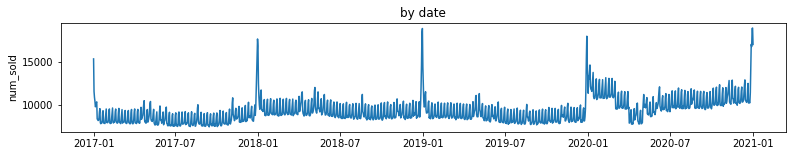

In [11]:
plt.figure(figsize=(13, 2))

train_date = train.groupby("date")[target].sum().reset_index()

plt.plot(train_date["date"], train_date[target])
plt.title("by date")
plt.ylabel(target)
plt.show()

In [12]:
train_date.head()

,date,num_sold
0,2017-01-01,15352
1,2017-01-02,11578
2,2017-01-03,10884
3,2017-01-04,10445
4,2017-01-05,9795


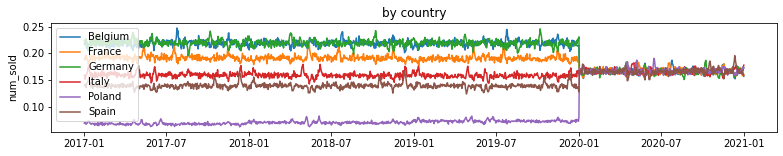

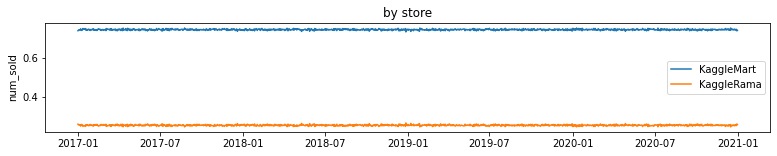

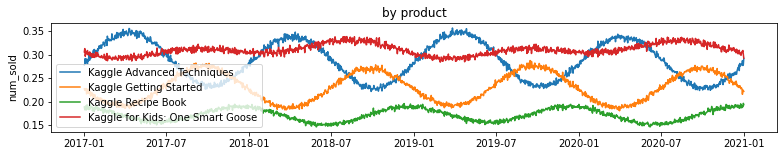

[0.7425193179463185, 0.25748068205368146]


In [13]:
columns = ["country", "store", "product"]
target = "num_sold"
ratios = []

ratio = True

for column in columns:
    plt.figure(figsize=(13, 2))
    
    for item in train[column].unique():
        data = train[train[column] == item]
        
        train_grouped = data.groupby(["date"])[target].sum().reset_index()
        
        if ratio:
            train_grouped[target] /= train_date[target]
            
        if column == "store":
            ratios.append(train_grouped[target].mean())
        
        plt.plot(train_grouped["date"], train_grouped[target], label=item)
        plt.title("by " + column)
        plt.ylabel(target)
    
    plt.legend()
    plt.show()
    
print(ratios)

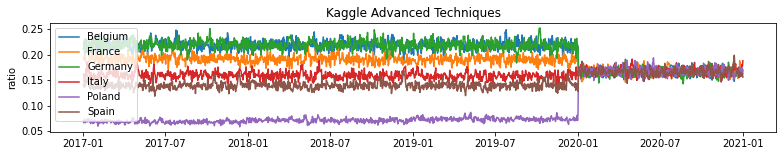

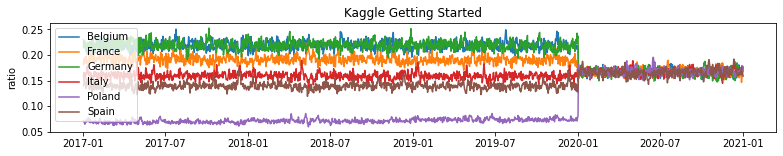

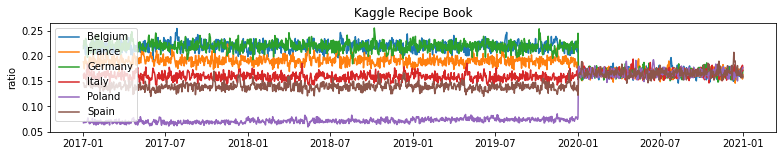

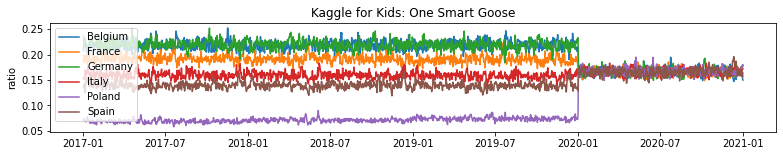

In [14]:
def per_element(base, element):
    elements = train[element].unique()
    
    for item in elements:
        plt.figure(figsize=(13, 2))

        data = train[train[element] == item]
        data_grouped = data.groupby(["date", base])[target].sum().reset_index().pivot(index="date",
                                                                            columns=base,
                                                                            values=target)

        data_grouped /= data_grouped.sum(axis=1).values.reshape((-1, 1))

        for column in data_grouped.columns:
            plt.plot(data_grouped.index, data_grouped[column], label=column)

        plt.title(item)
        plt.legend()
        plt.ylabel("ratio")

        plt.show()
        
per_element("country", "product")

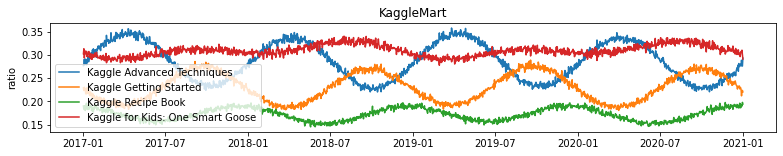

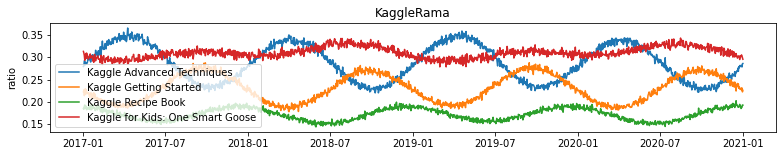

In [15]:
per_element("product", "store")

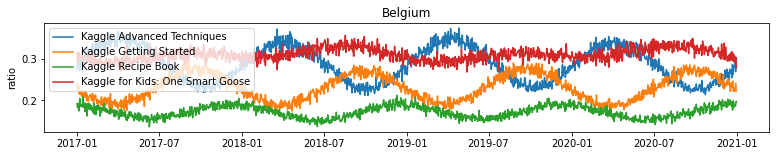

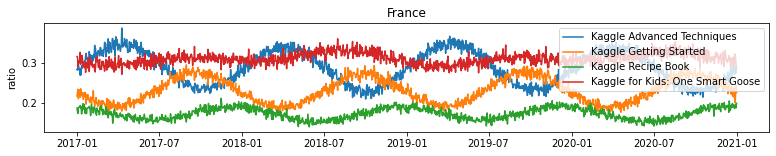

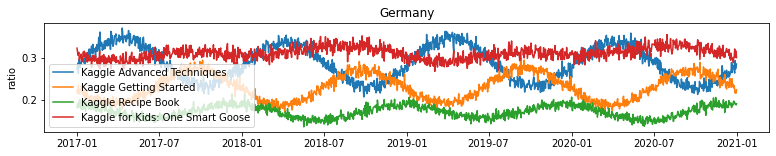

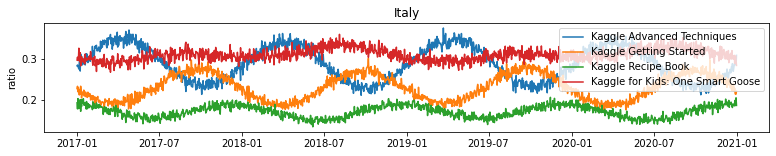

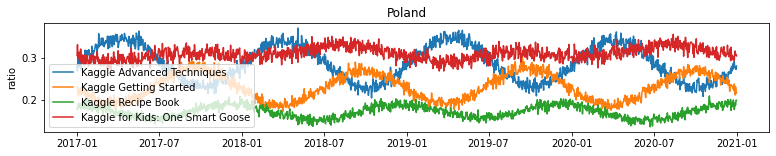

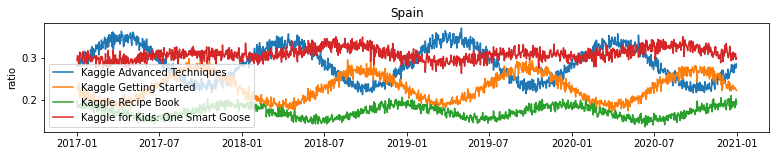

In [16]:
per_element("product", "country")

### модель для предсказания общего num_sold по дням

In [243]:
train_ = train[(train["date"] < pd.to_datetime("2020-01-01")) | (train["date"] > pd.to_datetime("2020-06-01"))].copy()

In [244]:
train_gp = train_.groupby("date")[target].sum().reset_index()[["date", target]]
train_gp.head()

,date,num_sold
0,2017-01-01,15352
1,2017-01-02,11578
2,2017-01-03,10884
3,2017-01-04,10445
4,2017-01-05,9795


In [245]:
test_gp = test.groupby("date").sum().reset_index()[["date"]]
test_gp[target] = -1.0
test_gp.head()

,date,num_sold
0,2021-01-01,-1.0
1,2021-01-02,-1.0
2,2021-01-03,-1.0
3,2021-01-04,-1.0
4,2021-01-05,-1.0


In [246]:
concat = train_gp.append(test_gp)
concat.head(5)

,date,num_sold
0,2017-01-01,15352.0
1,2017-01-02,11578.0
2,2017-01-03,10884.0
3,2017-01-04,10445.0
4,2017-01-05,9795.0


In [247]:
year = concat["date"].dt.year

weekday = pd.get_dummies(concat["date"].dt.dayofweek, prefix="dw").iloc[:, :-1]
day = pd.get_dummies(concat["date"].dt.day, prefix="d").iloc[:, :-1]
month = pd.get_dummies(concat["date"].dt.month, prefix="mn").iloc[:, :-1]

# day = pd.DataFrame({"day": concat["date"].dt.day})
# month = pd.DataFrame({"month": concat["date"].dt.month})
# weekday = pd.DataFrame({"day": concat["date"].dt.dayofweek})

In [248]:
all_data = concat.copy()
all_data["year"] = year
all_data = pd.concat([all_data, month], axis=1)
all_data = pd.concat([all_data, day], axis=1)
all_data = pd.concat([all_data, weekday], axis=1)

all_data.head()

,date,num_sold,year,mn_1,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,...,d_27,d_28,d_29,d_30,dw_0,dw_1,dw_2,dw_3,dw_4,dw_5
0,2017-01-01,15352.0,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-02,11578.0,2017,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2017-01-03,10884.0,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2017-01-04,10445.0,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2017-01-05,9795.0,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [273]:
train_data = all_data[all_data[target] != -1.0]
test_data  = all_data[all_data[target] == -1.0]

X = train_data[train_data.columns[2:]]
y = train_data[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75)

In [274]:
# reg = LinearRegression()
# reg = RandomForestRegressor(max_depth=10)
reg = Ridge()
# reg = AdaBoostRegressor()

reg.fit(X_train, y_train)

predict = reg.predict(X_val)
1 - np.sum((predict - y_val)**2) / np.sum((y_val.mean() - y_val)**2)

0.5357471541463712

In [275]:
target

'num_sold'

In [276]:
reg.fit(X, y)

X_test = test_data[test_data.columns[2:]]
predict = pd.DataFrame({target: reg.predict(X_test)})

In [277]:
predict.head()

,num_sold
0,11089.182196
1,11865.802113
2,12290.129503
3,10647.316946
4,10699.348834


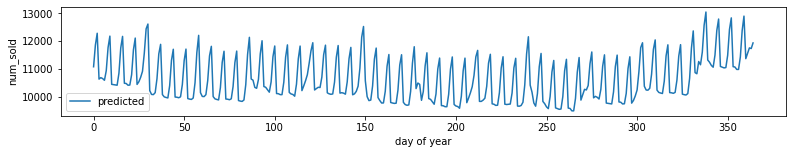

In [278]:
def plot(data, label):
    plt.figure(figsize=(13, 2))

    plt.plot(data, label=label)
    plt.xlabel("day of year")
    plt.ylabel(target)

    plt.title("")
    plt.legend()
    plt.show()
    
plot(predict, "predicted")

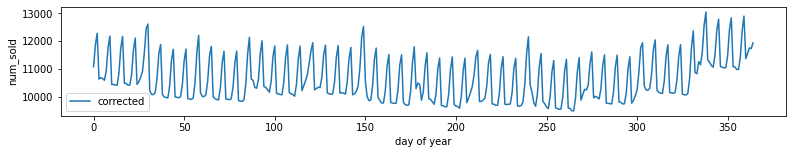

In [279]:
k = 0 # angle
b = 0 # offset

corrected = [value + b + index * k for index, value in enumerate(predict[target].values)]

plot(corrected, "corrected")

In [280]:
# test_data[target] = predict[target]
test_data[target] = corrected

test_data.head(5)

C:\Users\tka40\AppData\Local\Temp/ipykernel_9028/687590232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[target] = corrected


,date,num_sold,year,mn_1,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,...,d_27,d_28,d_29,d_30,dw_0,dw_1,dw_2,dw_3,dw_4,dw_5
0,2021-01-01,11089.182196,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2021-01-02,11865.802113,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2021-01-03,12290.129503,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-04,10647.316946,2021,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2021-01-05,10699.348834,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


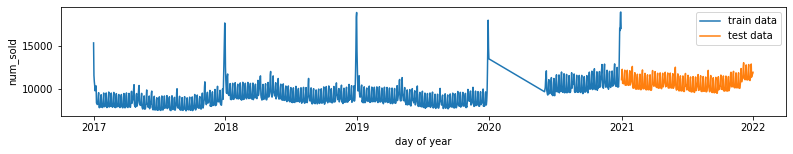

In [281]:
plt.figure(figsize=(13, 2))

plt.plot(train_data["date"], train_data[target], label="train data")
plt.plot(test_data["date"], test_data[target],
         label="test data")

plt.xlabel("day of year")
plt.ylabel(target)

plt.title("")
plt.legend()
plt.show()

In [282]:
train_data.sample(5)

,date,num_sold,year,mn_1,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,...,d_27,d_28,d_29,d_30,dw_0,dw_1,dw_2,dw_3,dw_4,dw_5
1155,2020-08-01,11028.0,2020,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
785,2019-02-25,8630.0,2019,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1191,2020-09-06,11581.0,2020,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,2017-01-14,9186.0,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
918,2019-07-08,7761.0,2019,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


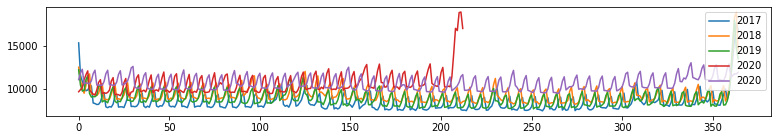

In [283]:
plt.figure(figsize=(13, 2))
for year in [2017, 2018, 2019, 2020]:
    plt.plot(train_data[train_data["year"] == year][target].values, label=str(year))

plt.plot(test_data[test_data["year"] == 2021][target].values, label=str(year))
plt.legend()
plt.show()

In [284]:
test_data.head(5)

,date,num_sold,year,mn_1,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,...,d_27,d_28,d_29,d_30,dw_0,dw_1,dw_2,dw_3,dw_4,dw_5
0,2021-01-01,11089.182196,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2021-01-02,11865.802113,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2021-01-03,12290.129503,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-04,10647.316946,2021,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2021-01-05,10699.348834,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### модель среднего для отношений по продуктам

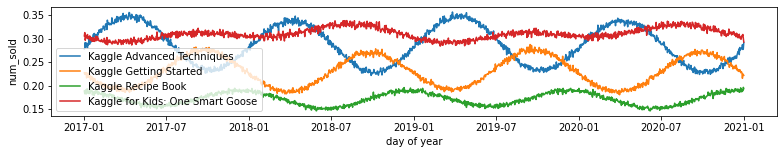

In [34]:
df_train = train.groupby(["date", 
                    "product"])[target].sum().reset_index().pivot(index="date",
                                                                  columns="product",
                                                                  values=target).reset_index()

df_train["total"] = df_train.iloc[:, 1:].sum(axis=1)

plt.figure(figsize=(13, 2))
for product in df_train.columns[1:-1]:
    df_train[product] /= df_train["total"]
    plt.plot(df_train["date"], df_train[product], label=product)
plt.legend()
plt.xlabel("day of year")
plt.ylabel(target)
plt.show()

In [35]:
day = pd.DataFrame({"day": df_train["date"].dt.dayofyear})

try:
    del df_train["total"]
except:
    pass

df_train["day"] = day
df_train.sample(5)

product,date,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose,day
676,2018-11-08,0.239717,0.261197,0.189671,0.309415,312
355,2017-12-22,0.275617,0.232473,0.187493,0.304418,356
284,2017-10-12,0.231008,0.271576,0.179974,0.317442,285
1445,2020-12-16,0.264944,0.233031,0.192441,0.309583,351
926,2019-07-16,0.284714,0.247969,0.157355,0.309961,197


In [36]:
df_test = pd.DataFrame(test_data["date"].copy())
day = pd.DataFrame({"day": df_test["date"].dt.dayofyear})
df_test["day"] = day

for product in df_train.columns[1: -1]:
    temp = pd.DataFrame(df_train[[product, "day"]].copy())
    mean = temp.groupby("day")[product].mean().values
    mapping = {key + 1: value for key, value in enumerate(mean)}
    df_test[product] = df_test["day"].map(mapping)

del df_test["day"]
df_test["day"] = day    
df_test.sample(5)

,date,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose,day
99,2021-04-10,0.344156,0.190393,0.166020,0.299431,100
4,2021-01-05,0.286850,0.223074,0.186379,0.303696,5
242,2021-08-31,0.241890,0.271053,0.166569,0.320488,243
348,2021-12-15,0.264667,0.239435,0.189019,0.306878,349
96,2021-04-07,0.337126,0.193190,0.165589,0.304095,97


In [37]:
df_data = df_train.copy()
df_data = df_data.append(df_test)

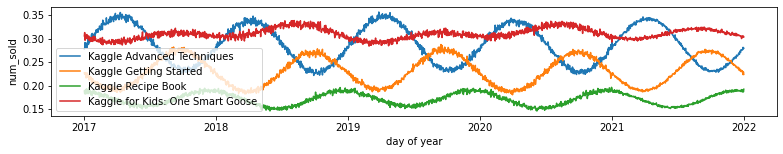

In [38]:
plt.figure(figsize=(13, 2))
for product in df_data.columns[1: -1]:
    plt.plot(df_data["date"], df_data[product], label=product)
plt.legend()
plt.xlabel("day of year")
plt.ylabel(target)
plt.show()

### расчёт цели

In [285]:
results = df_test[["date",
                   "Kaggle Advanced Techniques",
                   "Kaggle Getting Started",
                   "Kaggle Recipe Book",
                   "Kaggle for Kids: One Smart Goose"]].copy()

for product in results.columns[1:]:
    results[product] *= test_data[target]
    
results = results.set_index("date")
results.head(5)

,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose
date,,,,
2021-01-01,3083.930900,2523.480451,2112.066704,3369.704141
2021-01-02,3350.706944,2653.096602,2225.943636,3636.054931
2021-01-03,3485.867765,2790.544679,2289.109845,3724.607214
2021-01-04,3041.839158,2388.175463,2016.308072,3200.994253
2021-01-05,3069.110234,2386.751027,1994.139240,3249.348334


In [286]:
res = results.stack().reset_index().copy()
res.rename(columns={"level_1": "product", 0: target}, inplace=True)
res.head(5)

,date,product,num_sold
0,2021-01-01,Kaggle Advanced Techniques,3083.930900
1,2021-01-01,Kaggle Getting Started,2523.480451
2,2021-01-01,Kaggle Recipe Book,2112.066704
3,2021-01-01,Kaggle for Kids: One Smart Goose,3369.704141
4,2021-01-02,Kaggle Advanced Techniques,3350.706944


In [287]:
test.head(5)

,date,country,store,product
row_id,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [288]:
predictions = []

for index in tqdm(test.index):
    date = test.loc[index, "date"]
    country= test.loc[index, "country"]
    store = test.loc[index, "store"]
    product = test.loc[index, "product"]
    
    num_sold = res[(res["date"] == date) & (res["product"] == product)][target].values[0] / 6
    num_sold = num_sold * ratios[0] if store == "KaggleMart" else num_sold * ratios[1]
        
    predictions.append(num_sold)

  0%|          | 0/17520 [00:00<?, ?it/s]

In [289]:
p = np.array(predictions).reshape((-1, 1))
p

array([[381.64637804],
       [312.28883056],
       [261.37505477],
       ...,
       [114.88535921],
       [ 98.7670327 ],
       [155.56334098]])

In [290]:
s = submission.copy()
s[target] = p
s.head(5)

,row_id,num_sold
0,70128,381.646378
1,70129,312.288831
2,70130,261.375055
3,70131,417.011737
4,70132,132.342105


In [291]:
test_predicted = test.copy()

test_predicted[target] = p
test_predicted.head()

,date,country,store,product,num_sold
row_id,,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,381.646378
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,312.288831
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,261.375055
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,417.011737
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,132.342105


In [292]:
concat = train.append(test_predicted)
concat["date"] = pd.to_datetime(concat["date"])
concat.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663.0
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615.0
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710.0
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0


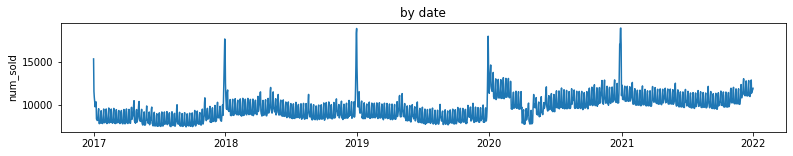

In [293]:
plt.figure(figsize=(13, 2))

concat_date = concat.groupby("date")[target].sum().reset_index()

plt.plot(concat_date["date"], concat_date[target])
plt.title("by date")
plt.ylabel(target)
plt.show()

In [294]:
s

,row_id,num_sold
0,70128,381.646378
1,70129,312.288831
2,70130,261.375055
3,70131,417.011737
4,70132,132.342105
...,...,...
17515,87643,448.611464
17516,87644,143.301369
17517,87645,114.885359
17518,87646,98.767033


In [296]:
k, b

(0, 0)

### отправка результатов

In [297]:
name = "submission.csv"
s.to_csv(name, index=False)

zout = zipfile.ZipFile(name +".zip", "w", zipfile.ZIP_DEFLATED)
zout.write(name)
zout.close()

In [298]:
!kaggle competitions submit -f submission.csv.zip -m linreg_cut_0_0 -c tabular-playground-series-sep-2022

400 - Bad Request


  0%|          | 0.00/84.8k [00:00<?, ?B/s]
  9%|9         | 8.00k/84.8k [00:00<00:01, 58.3kB/s]
100%|##########| 84.8k/84.8k [00:01<00:00, 45.7kB/s]


In [299]:
!kaggle competitions submissions -c tabular-playground-series-sep-2022

fileName              date                 description         status    publicScore  privateScore  
--------------------  -------------------  ------------------  --------  -----------  ------------  
submission.csv.zip    2022-09-11 06:07:03  linreg_1_0          complete  5.45651                    
submission.csv.zip    2022-09-11 06:03:38  linreg_0_120        complete  5.47935                    
submission.csv.zip    2022-09-11 06:01:15  linreg_0_0          complete  5.51850                    
submission.csv.zip    2022-09-11 05:57:43  rf_0_0              complete  6.81028                    
submission.csv.zip    2022-09-11 05:45:50  adaboost_0_0        complete  8.13599                    
submission.csv.zip    2022-09-10 14:42:17  composite_5_100     complete  5.72657                    
submission.csv.zip    2022-09-10 14:38:35  composite_0_300     complete  5.69507                    
submission.csv.zip    2022-09-10 06:14:23  composite_0_500     complete  6.28828           

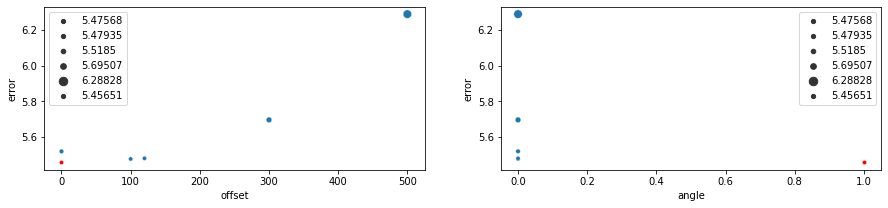

In [181]:
# noise = [1, 1, 1, 1, 1, 1, 1]

angle = [0, 0, 0, 0, 0, 1]

offset = [0, 100, 500, 300, 120, 0]

pscore = [5.5185, 5.47568, 6.28828, 5.69507, 5.47935, 5.45651]

fig = plt.figure(figsize=(15, 3))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.scatterplot(x=offset[:-1], y=pscore[:-1], ax=ax1, size=pscore[:-1])
sns.scatterplot(x=[offset[-1]], y=[pscore[-1]], ax=ax1, color="red", size=pscore[-1])
ax1.set_xlabel("offset")
ax1.set_ylabel("error")

sns.scatterplot(x=angle[:-1], y=pscore[:-1], ax=ax2, size=pscore[:-1])
sns.scatterplot(x=[angle[-1]], y=[pscore[-1]], ax=ax2, color="red", size=pscore[-1])
ax2.set_xlabel("angle")
ax2.set_ylabel("error")

plt.show()

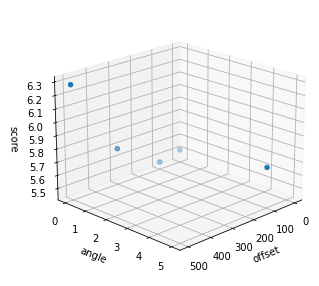

In [94]:
plt.figure(figsize=(6, 5))

axes = plt.axes(projection="3d")

axes.scatter3D(offset, angle, pscore)

axes.set_zlabel("score")
axes.set_ylabel("angle")
axes.set_xlabel("offset")
axes.view_init(20, 45)

plt.show()

### проба минимизации

In [374]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [384]:
score = []
angle = []
offset = []
noises = []

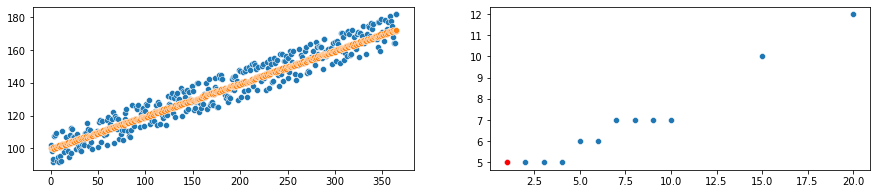

In [398]:
n = 366
k = 20
b = 100

noise = 1

x = np.linspace(0, 365, 366)
y = np.array([np.random.randint(-10, 10) + x / 5 + 100 for x in x])

a = np.array([np.random.randint(-noise, noise) + x * k / 100 + b for x in x])

error = np.sqrt(np.mean((y - a)**2))

score.append(int(error))
angle.append(k)
offset.append(b)
noises.append(noise)

fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.scatterplot(x=x, y=y, ax=ax1)
sns.scatterplot(x=x, y=a, ax=ax1)

sns.scatterplot(x=noises[:-1], y=score[:-1], ax=ax2)
sns.scatterplot(x=[noises[-1]], y=[score[-1]], ax=ax2, color="red")

plt.show()